### MIT Data Analysis and Visualization

#### Importing Libraries

In [1]:
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, welch, sosfiltfilt
import seaborn as sns
import os
import scipy.io as sio


In [2]:
data_dir = "./data/rawdata/mit/"

#### ERD Calculator Class

This uses a bandpass filter to calculate the ERD (Event-Related Desynchronization) from EEG data.


In [544]:
class ERDCalculator:
    """
    A class to calculate Event-Related Desynchronization (ERD) from EEG data.
    """
    def __init__(self, sampling_freq, epoch_pre_stimulus_seconds, epoch_post_stimulus_seconds, bandpass_low, bandpass_high, channel_names, focus_channels_indices, focus_stimuli=None):
        """
        Initializes the ERDCalculator with necessary parameters.

        Args:
            sampling_freq (float): The sampling frequency of the EEG data.
            epoch_pre_stimulus_seconds (float): Duration of the epoch before the stimulus in seconds.
            epoch_post_stimulus_seconds (float): Duration of the epoch after the stimulus in seconds.
            bandpass_low (float): The low cut-off frequency for the bandpass filter.
            bandpass_high (float): The high cut-off frequency for the bandpass filter.
            channel_names (list): A list of all channel names in the EEG data.
            focus_channels_indices (list): A list of indices for the channels of interest.
        """
        self.sampling_freq = sampling_freq
        # Samples before the marker
        self.samples_before_marker = int(epoch_pre_stimulus_seconds * sampling_freq)
        # Samples after the marker
        self.samples_after_marker = int(epoch_post_stimulus_seconds * sampling_freq)
        # Total samples in an epoch
        self.epoch_total_samples = self.samples_before_marker + self.samples_after_marker
        self.b, self.a = butter(3, [bandpass_low, bandpass_high], btype='band', fs=sampling_freq)
        self.channel_names = channel_names
        self.channel_count = len(channel_names)
        self.focus_channels_indices = focus_channels_indices
        self.bandpass_low = bandpass_low
        self.bandpass_high = bandpass_high
        self.focus_stimuli = focus_stimuli

    def calculate_erd(self, epoch_data):
        """
        Calculates the ERD for a given epoch.

        Args:
            epoch_data (np.array): The EEG data for a single epoch.

        Returns:
            float: The mean ERD percentage across the focus channels, or None if calculation is not possible.
        """
        # Validate the shape of the epoch data
        if epoch_data.shape != (self.channel_count, self.epoch_total_samples):
            print(f"Epoch data invalid. Shape: {epoch_data.shape}, Expected: ({self.channel_count}, {self.epoch_total_samples})")
            return None
        
        # Apply the bandpass filter
        filtered_epoch = filtfilt(self.b, self.a, epoch_data, axis=1)
        
        # Common Average Reference (CAR)
        filtered_epoch -= np.mean(filtered_epoch, axis=0, keepdims=True)
        # Ensure the filtered epoch is still valid
        if filtered_epoch.shape != (self.channel_count, self.epoch_total_samples):
            print(f"Filtered epoch invalid. Shape: {filtered_epoch.shape}, Expected: ({self.channel_count}, {self.epoch_total_samples})")
            return None

        # Separate pre and post-stimulus data
        pre_stimulus_data = filtered_epoch[:, :self.samples_before_marker]
        post_stimulus_data = filtered_epoch[:, self.samples_before_marker:]
        

        
        # pre_stimulus_data = filtered_epoch[:, self.samples_before_marker-int(0.2*self.sampling_freq):self.samples_before_marker]
        # post_stimulus_data = filtered_epoch[:, self.samples_before_marker:self.samples_before_marker + int(0.6*self.sampling_freq)]

        # Calculate power for pre and post stimulus periods
        # pre_power = np.nanmean(pre_stimulus_data ** 2, axis=1)
        # post_power = np.nanmean(post_stimulus_data ** 2, axis=1)
        
        
        pre_power = (pre_stimulus_data ** 2)
        post_power = (post_stimulus_data ** 2)
        

        # Calculate ERD, avoiding division by zero
        # non_zero_pre_power_indices = pre_power != 0
        # # print(post_power[non_zero_pre_power_indices], post_power[non_zero_pre_power_indices].shape)
        # erd_percent = np.full(self.channel_count, np.nan)
        # erd_percent[non_zero_pre_power_indices] = ((post_power[non_zero_pre_power_indices] - pre_power[non_zero_pre_power_indices]) / pre_power[non_zero_pre_power_indices]) * 100
  
        # # Extract ERD for focus channels
        # print(erd_percent.reshape(63, -1).shape)
        # erd_percent_focus = erd_percent[self.focus_channels_indices]
        
        baseline = np.mean(pre_power, axis=1, keepdims=True) # Shape: (n_channels, 1)

        # 2. Create a "safe" baseline to avoid division by zero errors.
        # We replace zeros with 1, which makes the division safe.
        # The result for these channels will be handled in the next step.
        safe_baseline = np.where(baseline == 0, 1, baseline)

        # 3. Calculate baseline correction for all channels
        post_power_after_baseline_correction = (post_power - safe_baseline) / safe_baseline

        # 4. For channels where the baseline was originally zero, the result is meaningless.
        # Set them to 0 or NaN (Not a Number) to exclude them from further analysis.
        post_power_after_baseline_correction[baseline.squeeze() == 0, :] = 0 # Or np.nan

        # 5. Calculate the final percentage for ALL channels
        erd_percent = np.mean(post_power_after_baseline_correction, axis=1) # Shape: (n_channels,)

        # 6. Now, safely select the channels you are interested in
        # Ensure self.focus_channels_indices is a 1D list or array of indices
        erd_percent_focus = erd_percent[self.focus_channels_indices]

                
        
        # Return the mean of the absolute ERD values for the focus channels
        if np.any(~np.isnan(erd_percent_focus)):
            return np.nanmean((erd_percent_focus))
        else:
            return None
    
    def calculate_erd_per_channel(self, epoch_data):
        """
        Calculates the ERD for a given epoch.

        Args:
            epoch_data (np.array): The EEG data for a single epoch.

        Returns:
            float: The mean ERD percentage across the focus channels, or None if calculation is not possible.
        """
        # Validate the shape of the epoch data
        if epoch_data.shape != (self.channel_count, self.epoch_total_samples):
            print(f"Epoch data invalid. Shape: {epoch_data.shape}, Expected: ({self.channel_count}, {self.epoch_total_samples})")
            return None
        
        # Apply the bandpass filter
        filtered_epoch = filtfilt(self.b, self.a, epoch_data, axis=1)
        
        # Common Average Reference (CAR)
        filtered_epoch -= np.mean(filtered_epoch, axis=0, keepdims=True)
        # Ensure the filtered epoch is still valid
        if filtered_epoch.shape != (self.channel_count, self.epoch_total_samples):
            print(f"Filtered epoch invalid. Shape: {filtered_epoch.shape}, Expected: ({self.channel_count}, {self.epoch_total_samples})")
            return None

        # Separate pre and post-stimulus data
        pre_stimulus_data = filtered_epoch[:, :self.samples_before_marker]
        post_stimulus_data = filtered_epoch[:, self.samples_before_marker:]
        
        # pre_stimulus_data = filtered_epoch[:, self.samples_before_marker-int(0.2*self.sampling_freq):self.samples_before_marker]
        # post_stimulus_data = filtered_epoch[:, self.samples_before_marker:self.samples_before_marker + int(0.6*self.sampling_freq)]

        # Calculate power for pre and post stimulus periods
        pre_power = np.nanmean(pre_stimulus_data ** 2, axis=1)
        post_power = np.nanmean(post_stimulus_data ** 2, axis=1)

        # Calculate ERD, avoiding division by zero
        non_zero_pre_power_indices = pre_power != 0
        erd_percent = np.full(self.channel_count, np.nan)
        erd_percent[non_zero_pre_power_indices] = ((post_power[non_zero_pre_power_indices] - pre_power[non_zero_pre_power_indices]) / pre_power[non_zero_pre_power_indices]) * 100
        
        # Extract ERD for focus channels
        erd_percent_focus = {channel: erd_percent[i] for i, channel in enumerate(self.channel_names) if i in self.focus_channels_indices}
        
        return erd_percent_focus
        
        # Return the mean of the absolute ERD values for the focus channels
        
    def calculate_erd_welch(self, epoch_data):
        """
        Calculates the ERD for a given epoch.

        Args:
            epoch_data (np.array): The EEG data for a single epoch.

        Returns:
            float: The mean ERD percentage across the focus channels, or None if calculation is not possible.
        """
        # Validate the shape of the epoch data
        if epoch_data.shape != (self.channel_count, self.epoch_total_samples):
            print(f"Epoch data invalid. Shape: {epoch_data.shape}, Expected: ({self.channel_count}, {self.epoch_total_samples})")
            return None
        


        # Separate pre and post-stimulus data
        pre_stimulus_data = epoch_data[:, :self.samples_before_marker]
        post_stimulus_data = epoch_data[:, self.samples_before_marker:]
        
        f_pre, Pxx_pre = welch(pre_stimulus_data, fs=self.sampling_freq, axis=1)
        f_post, Pxx_post = welch(post_stimulus_data, fs=self.sampling_freq,  axis=1)

        # Ensure the frequency bands are within the range of interest
        band_low_index = np.searchsorted(f_pre, self.bandpass_low)
        band_high_index = np.searchsorted(f_pre, self.bandpass_high)
        if band_low_index >= band_high_index:
            print("Invalid frequency band indices for ERD calculation.")
            return None
        # Extract the power in the alpha band (8-30 Hz)
        pre_power = np.nanmean(Pxx_pre[:, band_low_index:band_high_index], axis=1)
        post_power = np.nanmean(Pxx_post[:, band_low_index:band_high_index], axis=1)


        # Calculate ERD, avoiding division by zero
        non_zero_pre_power_indices = pre_power != 0
        erd_percent = np.full(self.channel_count, np.nan)
        erd_percent[non_zero_pre_power_indices] = ((post_power[non_zero_pre_power_indices] - pre_power[non_zero_pre_power_indices]) / pre_power[non_zero_pre_power_indices]) * 100
        
        # Extract ERD for focus channels
        erd_percent_focus = erd_percent[self.focus_channels_indices]
        
        # Return the mean of the absolute ERD values for the focus channels
        if np.any(~np.isnan(erd_percent_focus)):
            erd_percent_focus = np.nanmean((erd_percent_focus))
        else:
            erd_percent_focus = None
        
        return erd_percent_focus
    
    def calculate_erd_welch_per_channel(self, epoch_data):
        """
        Calculates the ERD for a given epoch.

        Args:
            epoch_data (np.array): The EEG data for a single epoch.

        Returns:
            float: The mean ERD percentage across the focus channels, or None if calculation is not possible.
        """
        # Validate the shape of the epoch data
        if epoch_data.shape != (self.channel_count, self.epoch_total_samples):
            print(f"Epoch data invalid. Shape: {epoch_data.shape}, Expected: ({self.channel_count}, {self.epoch_total_samples})")
            return None
        


        # Separate pre and post-stimulus data
        pre_stimulus_data = epoch_data[:, :self.samples_before_marker]
        post_stimulus_data = epoch_data[:, self.samples_before_marker:]
        
        f_pre, Pxx_pre = welch(pre_stimulus_data, fs=self.sampling_freq, axis=1)
        f_post, Pxx_post = welch(post_stimulus_data, fs=self.sampling_freq,  axis=1)

        # Ensure the frequency bands are within the range of interest
        band_low_index = np.searchsorted(f_pre, self.bandpass_low)
        band_high_index = np.searchsorted(f_pre, self.bandpass_high)
        if band_low_index >= band_high_index:
            print("Invalid frequency band indices for ERD calculation.")
            return None
        # Extract the power in the alpha band (8-30 Hz)
        pre_power = np.nanmean(Pxx_pre[:, band_low_index:band_high_index], axis=1)
        post_power = np.nanmean(Pxx_post[:, band_low_index:band_high_index], axis=1)


        # Calculate ERD, avoiding division by zero
        non_zero_pre_power_indices = pre_power != 0
        erd_percent = np.full(self.channel_count, np.nan)
        erd_percent[non_zero_pre_power_indices] = ((post_power[non_zero_pre_power_indices] - pre_power[non_zero_pre_power_indices]) / pre_power[non_zero_pre_power_indices]) * 100
        
        # Extract ERD for focus channels
        # erd_percent_focus = erd_percent[self.focus_channels_indices]
        
        erd_percent_focus = {channel: erd_percent[i] for i, channel in enumerate(self.channel_names) if i in self.focus_channels_indices}
        
        return erd_percent_focus
    
    def calculate_erd_across_trails(self, data_df, markers_df, subject_id=None):
            """
            Calculates ERD/ERS for each stimulus type.
            
            Args:
                data_df (pd.DataFrame): DataFrame with channels as columns and samples as rows.
                markers_df (pd.DataFrame): DataFrame with 'onset' (in samples) and 'description' columns.
            
            Returns:
                dict: A dictionary where keys are stimulus descriptions and values are the
                    calculated mean ERD/ERS percentages for the focus channels.
                    Returns an empty dictionary if no valid epochs are found.
            """
            # --- 1. GATHER AND GROUP EPOCHS BY STIMULUS ---


            epochs_by_stimulus = {}
            for row in markers_df.itertuples():
                onset_sample = row.onset
                stimulus_description = row.description
                
                
                # Filter for focus stimuli if specified
                if self.focus_stimuli and stimulus_description not in self.focus_stimuli:
                    continue
                print(f"Processing stimulus: {stimulus_description} at onset sample: {onset_sample}")

                # Define epoch boundaries
                start_sample = onset_sample - self.samples_before_marker
                end_sample = onset_sample + self.samples_after_marker

                # Ensure the epoch is within the data bounds
                if start_sample >= 0 and end_sample < len(data_df):
                    # Extract epoch data for all channels
                    epoch = data_df.iloc[start_sample:end_sample].values.T # (n_channels, n_samples)
                    
                    # Apply bandpass filter
                    epoch_filtered = filtfilt(self.b, self.a, epoch, axis=1)
                    
                    # Square to get instantaneous power
                    epoch_power = epoch_filtered**2
                    
                    # Group epochs by their stimulus description
                    if stimulus_description not in epochs_by_stimulus:
                        epochs_by_stimulus[stimulus_description] = []
                    epochs_by_stimulus[stimulus_description].append(epoch_power)
            
            # --- 2. CALCULATE ERD FOR EACH STIMULUS SEPARATELY ---
            erd_results = {}
            for stimulus, epochs_list in epochs_by_stimulus.items():
                if not epochs_list:
                    continue # Skip if for some reason the list is empty

                # Stack all epochs for the current stimulus into a 3D numpy array
                # Shape: (n_channels, n_timepoints, n_trials)
                epochs_stack = np.stack(epochs_list, axis=2)
                
                # Average power across all trials for this stimulus
                mean_power_across_trials = np.nanmean(epochs_stack, axis=2) # (n_channels, n_timepoints)
                
                # Define baseline (pre-marker) and activation (post-marker) periods
                baseline_power = mean_power_across_trials[:, :self.samples_before_marker]
                activation_power = mean_power_across_trials[:, self.samples_before_marker:]
                
                # Average the power across time for baseline and activation periods
                mean_baseline = np.nanmean(baseline_power, axis=1)    # (n_channels,)
                mean_activation = np.nanmean(activation_power, axis=1) # (n_channels,)
                
                # print((mean_baseline.shape), (mean_activation.shape), len(self.channel_names))
                # print(f"Mean Baseline: {mean_baseline}, Mean Activation: {mean_activation}")
                
                
                # Calculate ERD/ERS percentage, avoiding division by zero
                # ERD will be negative, ERS will be positive
                erd_percent = np.full(len(self.channel_names), np.nan)
                non_zero_indices = mean_baseline != 0
                
                erd_percent[non_zero_indices] = ((mean_activation[non_zero_indices] - mean_baseline[non_zero_indices]) / mean_baseline[non_zero_indices]) * 100
                
                # Extract ERD for focus channels
                erd_percent_focus = erd_percent[self.focus_channels_indices]
                
                # Calculate the mean ERD/ERS for the focus channels and store it
                if np.any(~np.isnan(erd_percent_focus)):
                    erd_results[stimulus] = np.nanmean(erd_percent_focus)
                else:
                    erd_results[stimulus] = None # Or np.nan
                
                if subject_id is not None:
                    erd_results['subject_id'] = subject_id

            return erd_results
    def calculate_erd_moving_average(self, epoch_data, window_size_samples):
            """
            Calculates the ERD for a given epoch using a moving average approach.
            It takes equal-sized moving windows from both pre and post-stimulus
            data, calculates ERD for each pair, and then averages these ERD values.

            Args:
                epoch_data (np.array): The EEG data for a single epoch.
                                    Expected shape: (self.channel_count, self.epoch_total_samples)
                window_size_samples (int): The size of the moving window in samples.

            Returns:
                float: The mean ERD percentage across the focus channels averaged
                    over all valid moving windows, or None if calculation is not possible.
            """
            # Validate initial epoch data shape
            if epoch_data.shape != (self.channel_count, self.epoch_total_samples):
                print(f"Epoch data invalid. Shape: {epoch_data.shape}, Expected: ({self.channel_count}, {self.epoch_total_samples})")
                return None

            # Apply bandpass filter
            filtered_epoch = filtfilt(self.b, self.a, epoch_data, axis=1)

            # Apply Common Average Reference (CAR)
            # This step should be done *after* filtering.
            filtered_epoch -= np.mean(filtered_epoch, axis=0, keepdims=True)

            # Validate filtered epoch shape
            if filtered_epoch.shape != (self.channel_count, self.epoch_total_samples):
                print(f"Filtered epoch invalid after CAR. Shape: {filtered_epoch.shape}, Expected: ({self.channel_count}, {self.epoch_total_samples})")
                return None

            # Separate pre and post-stimulus data
            pre_stimulus_data = filtered_epoch[:, :self.samples_before_marker]
            post_stimulus_data = filtered_epoch[:, self.samples_before_marker:]

            # Determine the number of samples available in pre and post segments
            pre_samples_len = pre_stimulus_data.shape[1]
            post_samples_len = post_stimulus_data.shape[1]

            # Check if window size is valid
            if window_size_samples <= 0:
                print("Window size must be a positive integer.")
                return None
            if window_size_samples > pre_samples_len or window_size_samples > post_samples_len:
                print(f"Window size ({window_size_samples}) is larger than pre ({pre_samples_len}) or post ({post_samples_len}) stimulus data length. Cannot calculate moving average ERD.")
                return None

            # Determine the maximum number of full windows that can be extracted
            # The number of windows is limited by the shorter segment to ensure equal pairs.
            max_windows = min(pre_samples_len, post_samples_len) - window_size_samples + 1

            if max_windows <= 0:
                print("Not enough samples to form any full window pairs.")
                return None

            erd_values_list = []

            # Iterate through the data with a sliding window (step size of 1 sample)
            for i in range(max_windows):
                # Extract current pre and post windows
                current_pre_window = pre_stimulus_data[:, i : i + window_size_samples]
                current_post_window = post_stimulus_data[:, i : i + window_size_samples]

                # Calculate power for the current windows
                # Use np.nanmean to handle potential NaN values if present, though with EEG data
                # it's usually clean after filtering.
                pre_power_window = np.nanmean(current_pre_window ** 2, axis=1)
                post_power_window = np.nanmean(current_post_window ** 2, axis=1)

                # Calculate ERD for the current window pair
                non_zero_pre_power_indices_window = pre_power_window != 0
                erd_percent_window = np.full(self.channel_count, np.nan) # Initialize with NaN

                # Calculate ERD only where pre_power_window is not zero
                erd_percent_window[non_zero_pre_power_indices_window] = (
                    (post_power_window[non_zero_pre_power_indices_window] - pre_power_window[non_zero_pre_power_indices_window]) /
                    pre_power_window[non_zero_pre_power_indices_window]
                ) * 100

                # Extract ERD for the focus channels for this window
                erd_percent_focus_window = erd_percent_window[self.focus_channels_indices]

                # If there are valid (non-NaN) ERD values for focus channels in this window,
                # calculate their mean and add to the list
                if np.any(~np.isnan(erd_percent_focus_window)):
                    erd_values_list.append(np.nanmean(erd_percent_focus_window))
                # Else, this window produced no meaningful ERD, so it's skipped from the list.

            # Calculate the final mean ERD from all accumulated window ERD values
            if erd_values_list:
                # return np.nanmean(erd_values_list)
                return erd_values_list
            else:
                print("No valid ERD values accumulated from any moving window.")
                return None




In [46]:
def analyze_single_subject(raw_data, focus_channel_names, subject_id, focus_stimuli=None):
    """
    Analyzes EEG data to calculate and visualize ERD values for different stimuli.

    Args:
        raw_data: The raw EEG data object from a file (e.g., MNE-Python Raw object).
        focus_channel_names (list): A list of channel names to focus on for ERD calculation.
    """
    # --- 1. Data Preparation ---
    df = raw_data.to_data_frame()
    sampling_frequency = raw_data.info['sfreq']
    channel_names = raw_data.ch_names
    annotations = raw_data.annotations

    # --- 2. Process Annotations ---
    annotations_df = pd.DataFrame({
        'onset': annotations.onset,
        'duration': annotations.duration,
        'description': annotations.description.astype(str),
    })
    annotations_df['absolute_onset'] = (annotations_df['onset'] * sampling_frequency).astype(int)
    annotations_df[['desc_main', 'desc_sub']] = (
    annotations_df['description']
      .str
      .split(pat='/', n=1, expand=True)
)

    annotations_df.drop(columns=['description', 'desc_main'], inplace=True)
    annotations_df.rename(columns={'desc_sub': 'description'}, inplace=True)

    # --- 3. Setup ERD Calculator ---
    epoch_pre_stimulus_seconds = 1.0
    epoch_post_stimulus_seconds = 1.0
    bandpass_low = 8.0
    bandpass_high = 30.0 # Alpha band
    focus_channels_indices = [channel_names.index(ch) for ch in focus_channel_names if ch in channel_names]

    erd_calculator = ERDCalculator(
        sampling_frequency,
        epoch_pre_stimulus_seconds,
        epoch_post_stimulus_seconds,
        bandpass_low,
        bandpass_high,
        channel_names,
        focus_channels_indices
    )

    # --- 4. ERD Calculation Loop ---
    results = []
    
    
    if annotations_df.empty:
        print("No annotations found for the specified stimuli.")
        return 
    for index, row in annotations_df.iterrows():
        onset_sample = row['absolute_onset']
        stimulus_description = row['description']
        
        # Filter for focus stimuli if specified
        if focus_stimuli and stimulus_description not in focus_stimuli:
            continue

        # Define epoch boundaries
        start_sample = onset_sample - erd_calculator.samples_before_marker
        end_sample = onset_sample + erd_calculator.samples_after_marker

        # Ensure the epoch is within the data bounds
        if start_sample >= 0 and end_sample < len(df):
            # Extract epoch data for all channels
            
            epoch_data = df.iloc[start_sample:end_sample][channel_names].values.T
            
            # Calculate ERD
            erd_value = erd_calculator.calculate_erd(epoch_data)

            if erd_value is not None:
                results.append({'stimulus': stimulus_description, 'erd_value': erd_value, 'subject_id': subject_id})

    # --- 5. Results and Visualization ---
    if results:
        results_df = pd.DataFrame(results)
        # print("ERD Calculation Results:")
        # print(results_df)
        return results_df
    else:
        print("No valid ERD results were calculated.")
        
def process_all_subjects(data_dir, focus_channel_names, focus_stimuli=None):
    """
    Processes all subjects in the specified data directory to calculate and visualize ERD values.

    Args:
        data_dir (str): Directory containing the EEG data files.
        focus_channel_names (list): List of channel names to focus on for ERD calculation.
        focus_stimuli (list, optional): List of stimuli descriptions to focus on. If None, all stimuli are processed.
    """
    results = []
    
    vhdr_files = [f for f in os.listdir(data_dir) if f.endswith('.vhdr')]
    
    for vhdr_file in vhdr_files:
        subject_id = vhdr_file.split('.')[0]  # Extract subject ID from filename
        vhdr_path = os.path.join(data_dir, vhdr_file)
        
        raw_data = mne.io.read_raw_brainvision(vhdr_path, preload=True)
        
        subject_results = analyze_single_subject(raw_data, focus_channel_names, subject_id, focus_stimuli)
        
        if subject_results is not None:
            results.append(subject_results)
    if results:
        all_results_df = pd.concat(results, ignore_index=True)
        return all_results_df
    else:
        print("No results found for any subjects.")
        return None

#### Processing EEG Data

In [480]:
results_df = process_all_subjects(data_dir, focus_channel_names=["C3", "C1", "CP3", "CP1"], focus_stimuli=['S  9', 'S 10', 'S 11'])

Extracting parameters from ./data/rawdata/mit/MIT1.vhdr...
Setting channel info structure...
Reading 0 ... 1098399  =      0.000 ...  1098.399 secs...
Extracting parameters from ./data/rawdata/mit/MIT10.vhdr...
Setting channel info structure...
Reading 0 ... 1269719  =      0.000 ...  1269.719 secs...


KeyboardInterrupt: 

#### Plotting ERD Results

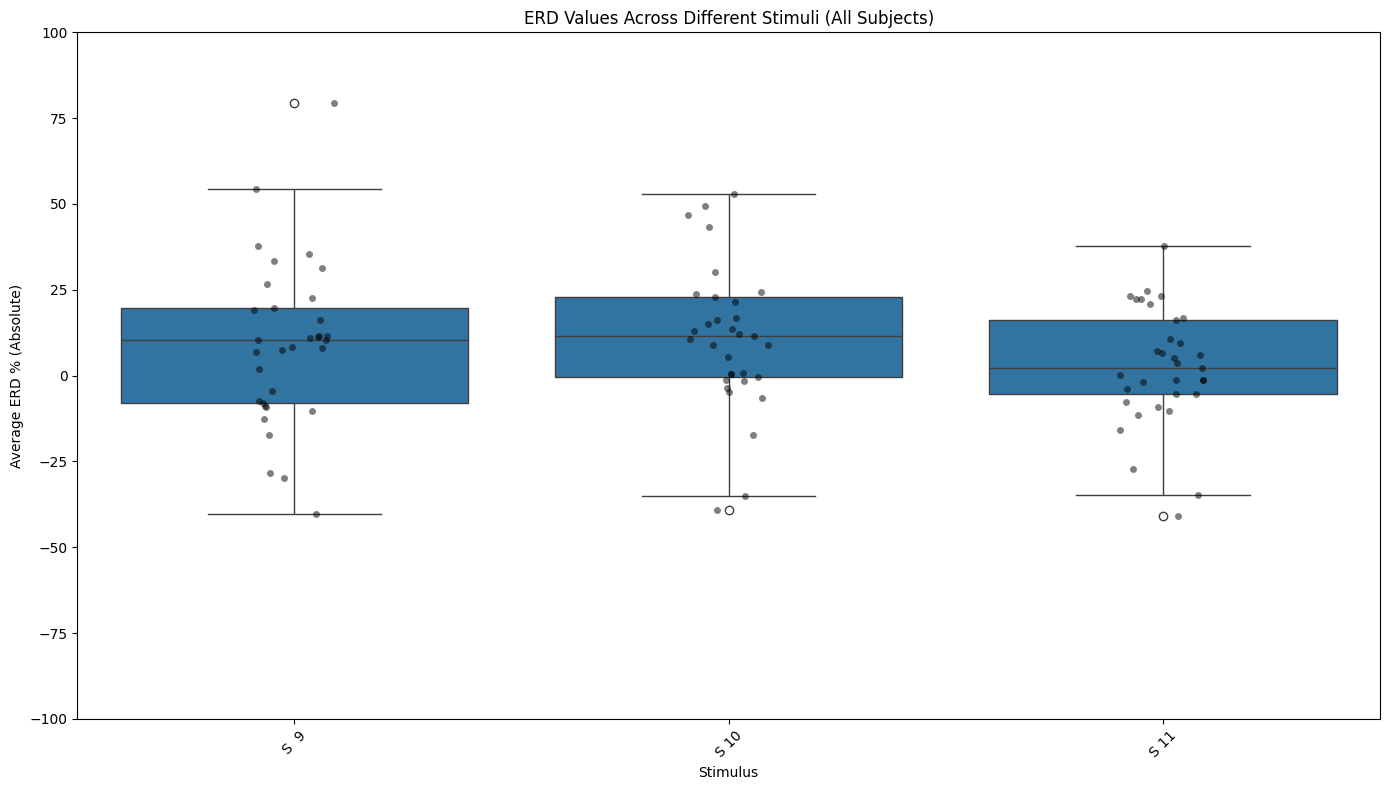

In [ ]:
avg_per_subject_stimulus = results_df.groupby(['subject_id', 'stimulus'])['erd_value'].mean().reset_index()
plt.figure(figsize=(14, 8))
sns.boxplot(x='stimulus', y='erd_value', data=avg_per_subject_stimulus)
sns.stripplot(x='stimulus', y='erd_value', data=avg_per_subject_stimulus, jitter=True, color='black', alpha=0.5, dodge=True)
plt.ylim(-100, 100)
plt.title('ERD Values Across Different Stimuli (All Subjects)')
plt.xlabel('Stimulus')
plt.ylabel('Average ERD % (Absolute)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### ERD Calculator Class (Welch)

This uses welch's method to calculate the ERD (Event-Related Desynchronization) from EEG data.

In [ ]:
def analyze_single_subject_welch(raw_data, focus_channel_names, subject_id, focus_stimuli=None):
    """
    Analyzes EEG data to calculate and visualize ERD values for different stimuli.

    Args:
        raw_data: The raw EEG data object from a file (e.g., MNE-Python Raw object).
        focus_channel_names (list): A list of channel names to focus on for ERD calculation.
    """
    # --- 1. Data Preparation ---
    df = raw_data.to_data_frame()
    sampling_frequency = raw_data.info['sfreq']
    channel_names = raw_data.ch_names
    annotations = raw_data.annotations

    # --- 2. Process Annotations ---
    annotations_df = pd.DataFrame({
        'onset': annotations.onset,
        'duration': annotations.duration,
        'description': annotations.description.astype(str),
    })
    annotations_df['absolute_onset'] = (annotations_df['onset'] * sampling_frequency).astype(int)
    annotations_df[['desc_main', 'desc_sub']] = (
    annotations_df['description']
      .str
      .split(pat='/', n=1, expand=True)
)

    annotations_df.drop(columns=['description', 'desc_main'], inplace=True)
    annotations_df.rename(columns={'desc_sub': 'description'}, inplace=True)

    # --- 3. Setup ERD Calculator ---
    epoch_pre_stimulus_seconds = 1.0
    epoch_post_stimulus_seconds = 1.0
    bandpass_low = 8.0
    bandpass_high = 30.0 # Alpha band
    focus_channels_indices = [channel_names.index(ch) for ch in focus_channel_names if ch in channel_names]

    erd_calculator = ERDCalculator(
        sampling_frequency,
        epoch_pre_stimulus_seconds,
        epoch_post_stimulus_seconds,
        bandpass_low,
        bandpass_high,
        channel_names,
        focus_channels_indices
    )

    # --- 4. ERD Calculation Loop ---
    results = []
    
    
    if annotations_df.empty:
        print("No annotations found for the specified stimuli.")
        return 
    for index, row in annotations_df.iterrows():
        onset_sample = row['absolute_onset']
        stimulus_description = row['description']
        
        # Filter for focus stimuli if specified
        if focus_stimuli and stimulus_description not in focus_stimuli:
            continue

        # Define epoch boundaries
        start_sample = onset_sample - erd_calculator.samples_before_marker
        end_sample = onset_sample + erd_calculator.samples_after_marker

        # Ensure the epoch is within the data bounds
        if start_sample >= 0 and end_sample < len(df):
            # Extract epoch data for all channels
            
            epoch_data = df.iloc[start_sample:end_sample][channel_names].values.T
            
            # Calculate ERD
            erd_value = erd_calculator.calculate_erd_welch(epoch_data)

            if erd_value is not None:
                results.append({'stimulus': stimulus_description, 'erd_value': erd_value, 'subject_id': subject_id})

    # --- 5. Results and Visualization ---
    if results:
        results_df = pd.DataFrame(results)
        # print("ERD Calculation Results:")
        # print(results_df)
        return results_df
    else:
        print("No valid ERD results were calculated.")
        
def process_all_subjects_welch(data_dir, focus_channel_names, focus_stimuli=None):
    """
    Processes all subjects in the specified data directory to calculate and visualize ERD values.

    Args:
        data_dir (str): Directory containing the EEG data files.
        focus_channel_names (list): List of channel names to focus on for ERD calculation.
        focus_stimuli (list, optional): List of stimuli descriptions to focus on. If None, all stimuli are processed.
    """
    results = []
    
    vhdr_files = [f for f in os.listdir(data_dir) if f.endswith('.vhdr')]
    
    for vhdr_file in vhdr_files:
        subject_id = vhdr_file.split('.')[0]  # Extract subject ID from filename
        vhdr_path = os.path.join(data_dir, vhdr_file)
        
        raw_data = mne.io.read_raw_brainvision(vhdr_path, preload=True)
        
        subject_results = analyze_single_subject_welch(raw_data, focus_channel_names, subject_id, focus_stimuli)
        
        if subject_results is not None:
            results.append(subject_results)
    if results:
        all_results_df = pd.concat(results, ignore_index=True)
        return all_results_df
    else:
        print("No results found for any subjects.")
        return None

#### Processing EEG Data

In [ ]:
results_welch_df = process_all_subjects_welch(data_dir, focus_channel_names=["C3", "C1", "CP3", "CP1"], focus_stimuli=['S  9', 'S 10', 'S 11'])


Extracting parameters from ./data/rawdata/mit/MIT1.vhdr...
Setting channel info structure...
Reading 0 ... 1098399  =      0.000 ...  1098.399 secs...
Extracting parameters from ./data/rawdata/mit/MIT10.vhdr...
Setting channel info structure...
Reading 0 ... 1269719  =      0.000 ...  1269.719 secs...
Extracting parameters from ./data/rawdata/mit/MIT11.vhdr...
Setting channel info structure...
Reading 0 ... 1174599  =      0.000 ...  1174.599 secs...
Extracting parameters from ./data/rawdata/mit/MIT12.vhdr...
Setting channel info structure...
Reading 0 ... 1445479  =      0.000 ...  1445.479 secs...
Extracting parameters from ./data/rawdata/mit/MIT13.vhdr...
Setting channel info structure...
Reading 0 ... 1119699  =      0.000 ...  1119.699 secs...
Extracting parameters from ./data/rawdata/mit/MIT14.vhdr...
Setting channel info structure...
Reading 0 ... 1213539  =      0.000 ...  1213.539 secs...
Extracting parameters from ./data/rawdata/mit/MIT15.vhdr...
Setting channel info structur

#### Plotting ERD Results

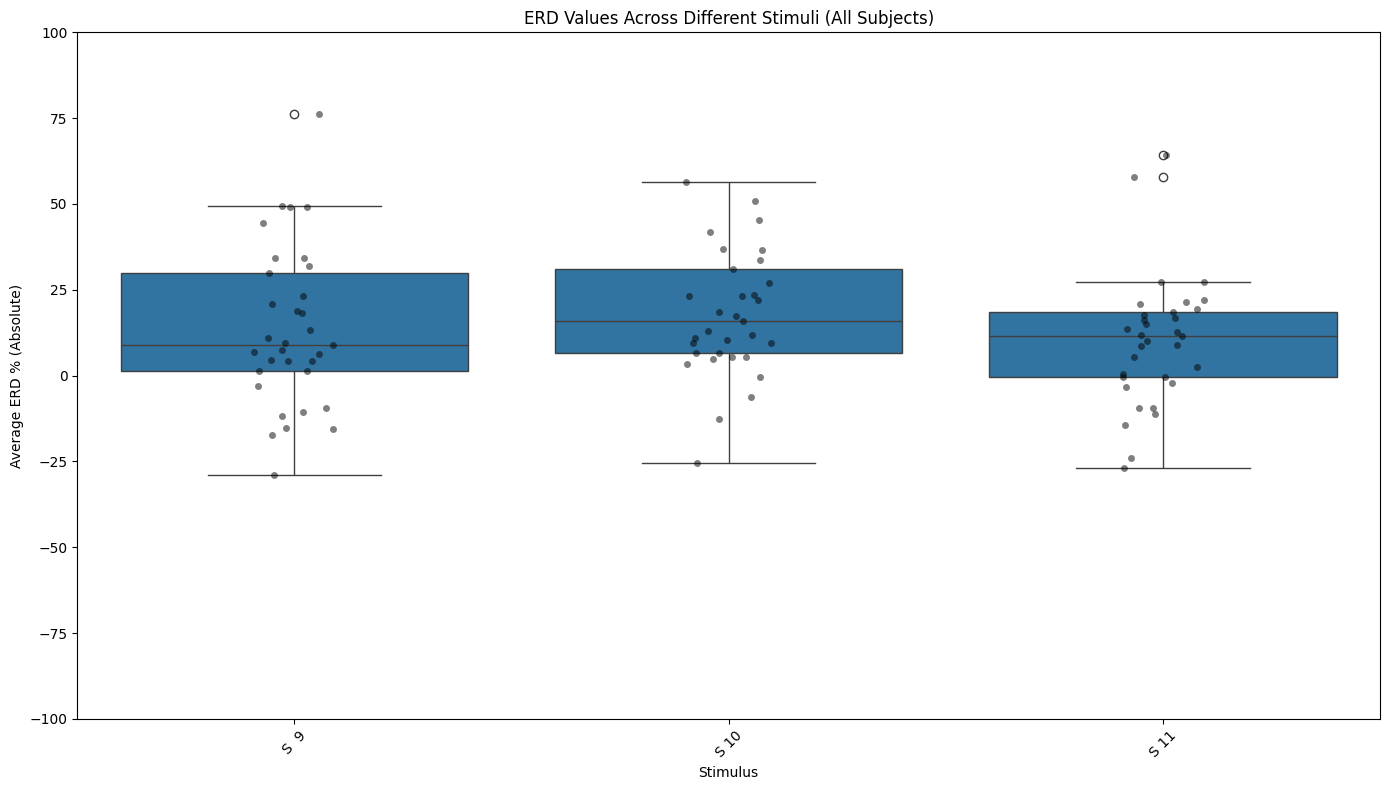

In [ ]:
avg_per_subject_stimulus = results_welch_df.groupby(['subject_id', 'stimulus'])['erd_value'].mean().reset_index()
plt.figure(figsize=(14, 8))
sns.boxplot(x='stimulus', y='erd_value', data=avg_per_subject_stimulus)
sns.stripplot(x='stimulus', y='erd_value', data=avg_per_subject_stimulus, jitter=True, color='black', alpha=0.5, dodge=True)
plt.ylim(-100, 100)
plt.title('ERD Values Across Different Stimuli (All Subjects)')
plt.xlabel('Stimulus')
plt.ylabel('Average ERD % (Absolute)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 5F Data Analysis and Visualization

#### Restructuring Data

In [5]:
def load_and_process_mat_file(file_path):
    """
    Loads and processes a .mat file to extract and format EEG data and markers.

    Args:
        file_path (str): The full path to the .mat file.

    Returns:
        tuple: A tuple containing:
            - data_df (pd.DataFrame): DataFrame with EEG data, columns as channel names.
            - markers_df (pd.DataFrame): DataFrame with filtered event markers.
            - sampling_frequency (int): The sampling frequency of the data.
            - num_samples (int): The total number of samples in the recording.
            - channel_names (list): List of channel names in the data.
    """
    # Load the .mat file
    raw_data = sio.loadmat(file_path)

    # Extract metadata and data
    o = raw_data['o'][0][0]
    sampling_frequency = o[2][0][0]
    num_samples = o[3][0][0]
    markers = o[4]
    data = o[5]
    channel_names = [channel[0][0] for channel in o[6]]

    # Create a DataFrame for the EEG data
    data_df = pd.DataFrame(data, columns=channel_names)

    # Create and process the markers DataFrame
    markers_df = pd.DataFrame(markers, columns=['description'])
    markers_df.reset_index(inplace=True)
    markers_df.rename(columns={'index': 'onset'}, inplace=True)

    # Identify the start of a new, non-zero marker
    is_new_marker_start = (markers_df['description'] != 0) & \
                          (markers_df['description'].shift(1) != markers_df['description'])

    # Filter the markers to keep only the start of new events
    markers_df = markers_df[is_new_marker_start].copy()

    return data_df, markers_df, sampling_frequency, num_samples, channel_names

In [15]:
def compute_tfr_from_mat(file_path, tmin=-1.5, tmax=1.5, baseline=(-1.0, 0)):
    """
    Orchestrates the loading of a .mat file and computes the Time-Frequency
    Representation (TFR) using MNE.

    Args:
        file_path (str): Path to the .mat file.
        tmin (float): Start time of the epoch in seconds, relative to the event.
        tmax (float): End time of the epoch in seconds, relative to the event.
        baseline (tuple): The time interval to use for baseline correction.

    Returns:
        mne.time_frequency.TFR: The computed TFR object.
    """
    # 1. Load data using your custom function
    print(f"Loading and processing file: {file_path}...")
    data_df, markers_df, sfreq, _, ch_names = load_and_process_mat_file(file_path)

    # 2. Prepare data for MNE's RawArray object
    # MNE expects data in shape (n_channels, n_samples)
    data_for_mne = data_df.values.T
    
    # IMPORTANT: MNE expects data in Volts. If your data is in microvolts (uV),
    # you must scale it: data_for_mne = data_for_mne * 1e-6
    
    # Assume channel types are 'eeg'. Adjust if you have other types.
    ch_types = ['eeg'] * len(ch_names)
    
    # 3. Create the MNE Info and RawArray objects
    print("Creating MNE Raw object...")
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
    raw = mne.io.RawArray(data_for_mne, info)

    # 4. Convert your markers_df into an MNE-compatible events array
    # The MNE events array is a NumPy array of shape (n_events, 3)
    # with columns: [sample_onset, duration, event_id]
    print("Formatting events...")
    events = np.array([
        markers_df['onset'],
        np.zeros(len(markers_df)),  # Duration column (usually 0)
        markers_df['description']
    ]).T.astype(int)

    # Create an event_id dictionary for MNE. This maps a descriptive string
    # to the integer marker value. We create it dynamically from the markers.
    unique_markers = markers_df['description'].unique()
    event_id = {f"event_{marker}": marker for marker in unique_markers}
    print(f"Found event IDs: {event_id}")

    # 5. Create Epochs
    print("Creating epochs...")
    epochs = mne.Epochs(raw,
                        events,
                        event_id,
                        tmin=tmin,
                        tmax=tmax,
                        preload=True,
                        baseline=None) # Baseline will be applied to the TFR later

    # 6. Compute TFR
    print("Computing TFR...")
    freqs = np.arange(8., 30.)  # 8 to 30 Hz
    n_cycles = freqs / 2.  # Use a variable number of cycles

    tfr = epochs.compute_tfr(method='multitaper',
                             freqs=freqs,
                             n_cycles=n_cycles,
                             use_fft=True,
                             return_itc=False,
                             average=False) # Average across epochs for each condition

    # 7. Apply baseline correction
    print("Applying baseline correction...")
    tfr.apply_baseline(mode='percent', baseline=baseline)

    print("TFR computation complete.")
    return tfr

#### Analyzing Data Using MNE

In [16]:
data_dir = "./data/rawdata/nature/"

In [17]:
focus_channel_names = ["Fp1", "C3", "O2", "O1", "Fp2"]
focus_stimuli=[1, 2, 3, 4, 5]
epoch_pre_stimulus_seconds = 1.0
epoch_post_stimulus_seconds = 1.0
bandpass_low = 8.0
bandpass_high = 30.0 # Alpha band

In [18]:
tfr = compute_tfr_from_mat(os.path.join(data_dir, '5F-SubjectA-160405-5St-SGLHand.mat'), tmin=-1.5, tmax=1.5, baseline=(-1.0, 0))

Loading and processing file: ./data/rawdata/nature/5F-SubjectA-160405-5St-SGLHand.mat...
Creating MNE Raw object...
Creating RawArray with float64 data, n_channels=22, n_times=718600
    Range : 0 ... 718599 =      0.000 ...  3592.995 secs
Ready.
Formatting events...
Found event IDs: {'event_99': np.uint8(99), 'event_1': np.uint8(1), 'event_4': np.uint8(4), 'event_2': np.uint8(2), 'event_5': np.uint8(5), 'event_3': np.uint8(3), 'event_91': np.uint8(91), 'event_92': np.uint8(92)}
Creating epochs...
Not setting metadata
967 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 967 events and 601 original time points ...
0 bad epochs dropped
Computing TFR...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   15.1s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:   19.5s finished


Applying baseline correction...
Applying baseline correction (mode: percent)
TFR computation complete.


In [22]:
tfr_df = tfr.copy().crop(-1,1).to_data_frame()

In [23]:
tfr_df=tfr_df.groupby(['condition', 'time', 'freq']).mean().reset_index().drop(columns=['epoch'])
tfr_df

,condition,time,freq,Fp1,Fp2,F3,F4,C3,C4,P3,...,F7,F8,T3,T4,T5,T6,Fz,Cz,Pz,X5
0,event_1,-1.0,8.0,1.160613,1.173908,0.241179,0.352378,0.049933,0.052007,0.069226,...,0.257458,0.596747,0.104680,0.171387,0.077531,0.109924,0.218589,0.021404,0.095233,-0.991315
1,event_1,-1.0,9.0,0.899498,0.945308,0.167418,0.266995,0.069427,0.078385,0.088473,...,0.239994,0.422232,0.105306,0.171755,0.064158,0.120524,0.162198,-0.025386,0.088165,-0.990711
2,event_1,-1.0,10.0,0.647902,0.763341,0.064869,0.260737,0.135231,0.148356,0.124352,...,0.086536,0.428066,0.105029,0.198209,0.079412,0.129683,0.116008,0.005618,0.092340,-0.989116
3,event_1,-1.0,11.0,0.591145,0.695708,0.057593,0.192140,0.099125,0.092480,0.118513,...,0.083570,0.341561,0.093409,0.223010,0.090551,0.149928,0.081486,0.079142,0.102173,-0.988348
4,event_1,-1.0,12.0,0.508459,0.629042,0.031793,0.212046,0.082207,0.074911,0.133619,...,0.051720,0.320339,0.099600,0.186118,0.149491,0.123819,0.112624,0.068348,0.092113,-0.985697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70571,event_99,1.0,25.0,0.478987,0.337119,0.617637,-0.328341,0.211154,0.274349,0.257844,...,0.766681,0.208493,0.588447,0.284173,0.262885,0.382685,0.154226,0.593228,0.998044,-0.953185
70572,event_99,1.0,26.0,0.391583,0.383222,1.029967,-0.354792,0.251370,0.151836,0.445998,...,0.999373,0.250211,0.531700,0.510576,0.457768,1.075285,0.294533,0.601161,1.007744,-0.954923
70573,event_99,1.0,27.0,0.270889,0.162387,0.738608,-0.354424,0.268723,0.357679,0.403807,...,1.002429,0.161812,0.389910,0.739498,0.560881,1.139323,0.143038,0.775224,1.400161,-0.959367
70574,event_99,1.0,28.0,0.350978,0.608374,0.751705,0.108220,0.448396,0.812761,0.186169,...,0.805468,0.627932,0.190490,0.969110,0.164270,1.072325,0.235769,0.842309,0.669512,-0.960487


In [24]:
conditions = ['event_1', 'event_4', 'event_2', 'event_5', 'event_3']
channels = ['Fp1', 'C3', 'O2', 'O1', 'Fp2']

In [ ]:
for condition in conditions:
    
    # REMOVED the inner loop: "for channel in channels:"
    print(f"Generating plot for: Condition '{condition}' (averaged over all channels)")

    # --- Step 1: Select the data for the current condition ---
    condition_df = tfr_df[tfr_df['condition'] == condition].copy() # Use .copy() to avoid SettingWithCopyWarning
    
    # --- Step 2: NEW - Calculate the mean across the channel columns for each row ---
    # The axis=1 argument tells pandas to average horizontally across the columns
    condition_df['mean_channels'] = condition_df[channels].mean(axis=1)

    # --- Step 3: Pivot the data using the new 'mean_channels' column ---
    plot_matrix = condition_df.pivot_table(index='freq', columns='time', values='mean_channels')
    
    # --- Step 4: Create the plot (the rest of the code is mostly the same) ---
    fig, ax = plt.subplots(figsize=(10, 6))
    
    cmap = 'RdBu_r'
    
    vmax = np.max(np.abs(plot_matrix.values))
    vmin = -vmax

    mesh = ax.pcolormesh(
        plot_matrix.columns, 
        plot_matrix.index, 
        plot_matrix.values, 
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        shading='gouraud'
    )

    cbar = fig.colorbar(mesh, ax=ax)
    cbar.set_label('ERD/ERS (%)')

    # CHANGED: Update the plot title
    ax.set_title(f'Average ERD/ERS across all channels - {condition}')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Frequency (Hz)')
    
    ax.axvline(0, color='black', linestyle='--', linewidth=1.5)
    
    plt.show()

### Full MIT data analysis and visualization

#### Using Custom Functions

In [ ]:
data_dir = "./data/rawdata/mit/"

In [ ]:
def analyze_single_subject(raw_data, focus_channel_names, subject_id, focus_stimuli=None):
    """
    Analyzes EEG data to calculate and visualize ERD values for different stimuli.

    Args:
        raw_data: The raw EEG data object from a file (e.g., MNE-Python Raw object).
        focus_channel_names (list): A list of channel names to focus on for ERD calculation.
    """
    # --- 1. Data Preparation ---
    df = raw_data.to_data_frame()
    sampling_frequency = raw_data.info['sfreq']
    channel_names = raw_data.ch_names
    annotations = raw_data.annotations
    
    df.drop(columns=['time'], inplace=True)  # Remove time column if it exists
    

    # --- 2. Process Annotations ---
    annotations_df = pd.DataFrame({
        'onset': annotations.onset,
        'duration': annotations.duration,
        'description': annotations.description.astype(str),
    })
    annotations_df['absolute_onset'] = (annotations_df['onset'] * sampling_frequency).astype(int)
    annotations_df[['desc_main', 'desc_sub']] = (
    annotations_df['description']
      .str
      .split(pat='/', n=1, expand=True)
)

    annotations_df.drop(columns=['description', 'desc_main', 'onset'], inplace=True)
    annotations_df.rename(columns={'desc_sub': 'description'}, inplace=True)
    annotations_df.rename(columns={'absolute_onset': 'onset'}, inplace=True)

    # --- 3. Setup ERD Calculator ---
    epoch_pre_stimulus_seconds = 1.0
    epoch_post_stimulus_seconds = 1.0
    bandpass_low = 8.0
    bandpass_high = 30.0 # Alpha band
    focus_channels_indices = [channel_names.index(ch) for ch in focus_channel_names if ch in channel_names]

    erd_calculator = ERDCalculator(
        sampling_frequency,
        epoch_pre_stimulus_seconds,
        epoch_post_stimulus_seconds,
        bandpass_low,
        bandpass_high,
        channel_names,
        focus_channels_indices,
        focus_stimuli=focus_stimuli
    )
    
    return erd_calculator.calculate_erd_across_trails(df, annotations_df[annotations_df['description'].isin(focus_stimuli)].copy(), subject_id=subject_id)

    # --- 4. ERD Calculation Loop ---
    
        
def process_all_subjects(data_dir, focus_channel_names, focus_stimuli=None):
    """
    Processes all subjects in the specified data directory to calculate and visualize ERD values.

    Args:
        data_dir (str): Directory containing the EEG data files.
        focus_channel_names (list): List of channel names to focus on for ERD calculation.
        focus_stimuli (list, optional): List of stimuli descriptions to focus on. If None, all stimuli are processed.
    """
    results = []
    
    vhdr_files = [f for f in os.listdir(data_dir) if f.endswith('.vhdr')]
    
    for vhdr_file in vhdr_files:
        subject_id = vhdr_file.split('.')[0]  # Extract subject ID from filename
        vhdr_path = os.path.join(data_dir, vhdr_file)
        
        raw_data = mne.io.read_raw_brainvision(vhdr_path, preload=True)
        
        subject_results = analyze_single_subject(raw_data, focus_channel_names, subject_id, focus_stimuli)
        
        if subject_results is not None:
            results.append(subject_results)
    if results:
        all_results_df = pd.DataFrame(results)
        return all_results_df
    else:
        print("No results found for any subjects.")
        return None

In [ ]:
result = process_all_subjects(data_dir, focus_channel_names=["C3", "C1", "CP3", "CP1"], focus_stimuli=['S  9', 'S 10', 'S 11'])

Extracting parameters from ./data/rawdata/mit/MIT1.vhdr...
Setting channel info structure...
Reading 0 ... 1098399  =      0.000 ...  1098.399 secs...
Processing stimulus: S  9 at onset sample: 17393
Processing stimulus: S  9 at onset sample: 22585
Processing stimulus: S  9 at onset sample: 32351
Processing stimulus: S  9 at onset sample: 37617
Processing stimulus: S  9 at onset sample: 42690
Processing stimulus: S 10 at onset sample: 60987
Processing stimulus: S 10 at onset sample: 66212
Processing stimulus: S 10 at onset sample: 75274
Processing stimulus: S 10 at onset sample: 80637
Processing stimulus: S 10 at onset sample: 85668
Processing stimulus: S 11 at onset sample: 104515
Processing stimulus: S 11 at onset sample: 109822
Processing stimulus: S 11 at onset sample: 114952
Processing stimulus: S 11 at onset sample: 120006
Processing stimulus: S 11 at onset sample: 125032
Processing stimulus: S 11 at onset sample: 143013
Processing stimulus: S 11 at onset sample: 148287
Processin

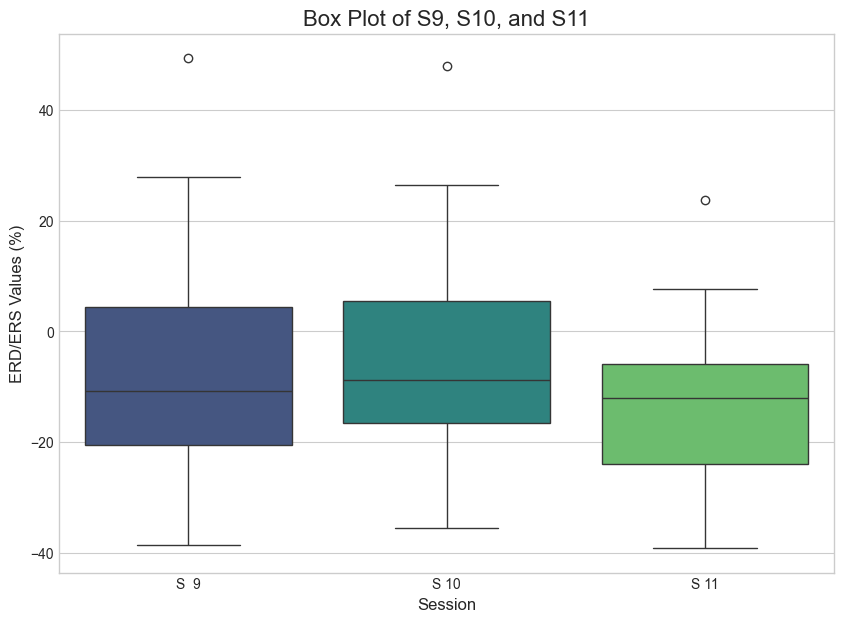

In [ ]:
df_to_plot = result[['S  9', 'S 10', 'S 11']]

# 2. Create the box plot using seaborn
plt.style.use('seaborn-v0_8-whitegrid') # Using a nice style for the plot
plt.figure(figsize=(10, 7)) # Set the figure size

sns.boxplot(data=df_to_plot, palette='viridis')

# 3. Add titles and labels for clarity
plt.title('Box Plot of S9, S10, and S11', fontsize=16)
plt.ylabel('ERD/ERS Values (%)', fontsize=12)
plt.xlabel('Session', fontsize=12)

# 4. Show the plot
plt.show()

### Full 5F Data Analysis and Visualization

#### Using MNE

Loading data from results/aggregated_5F_tfr.parquet...
Data loaded successfully.
Generating plot for: Condition 'event_1' (averaged over all channels)


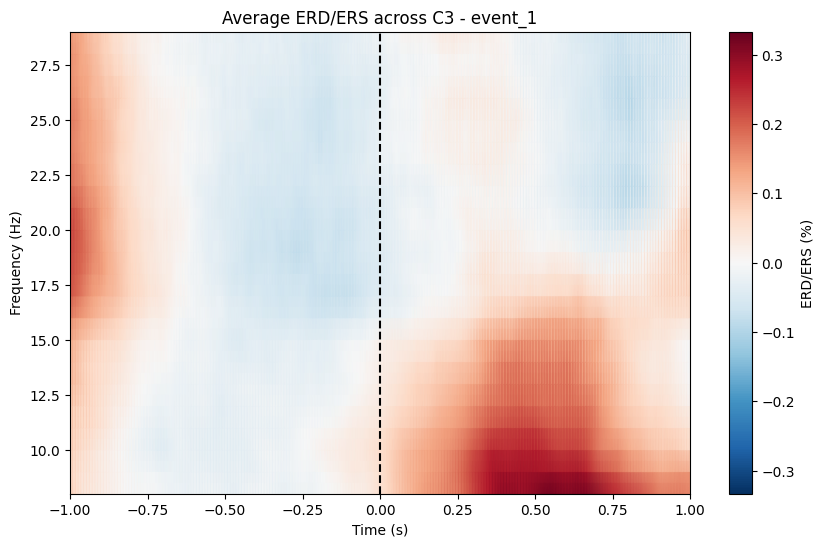

Generating plot for: Condition 'event_4' (averaged over all channels)


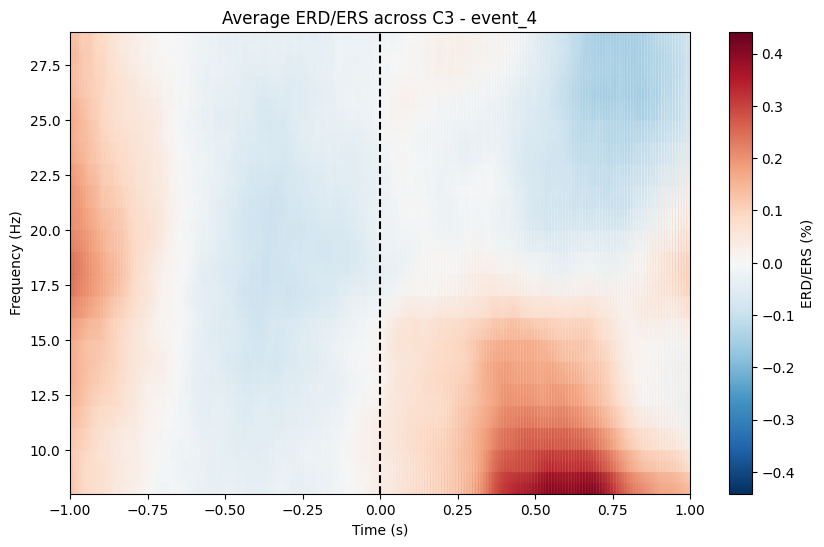

Generating plot for: Condition 'event_2' (averaged over all channels)


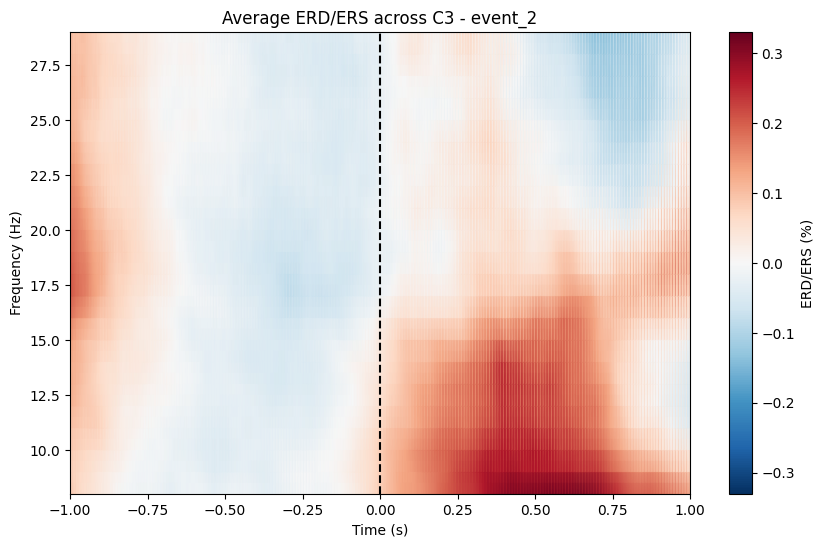

Generating plot for: Condition 'event_5' (averaged over all channels)


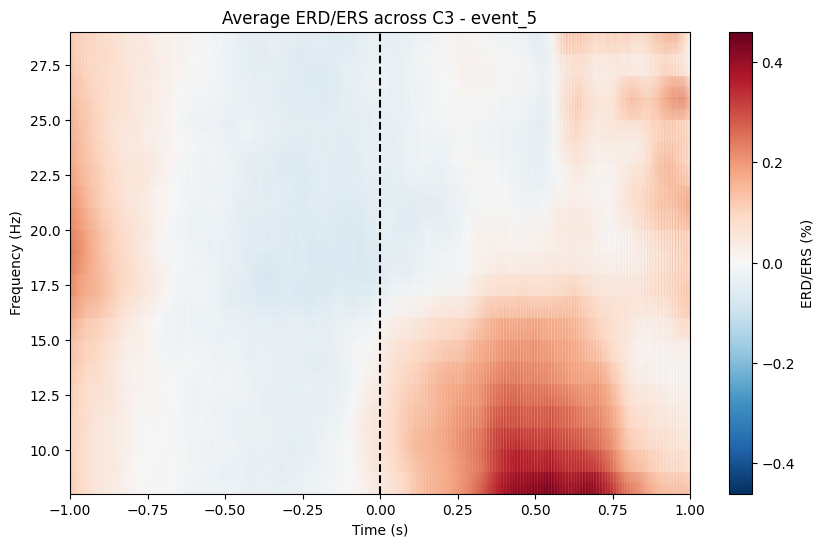

Generating plot for: Condition 'event_3' (averaged over all channels)


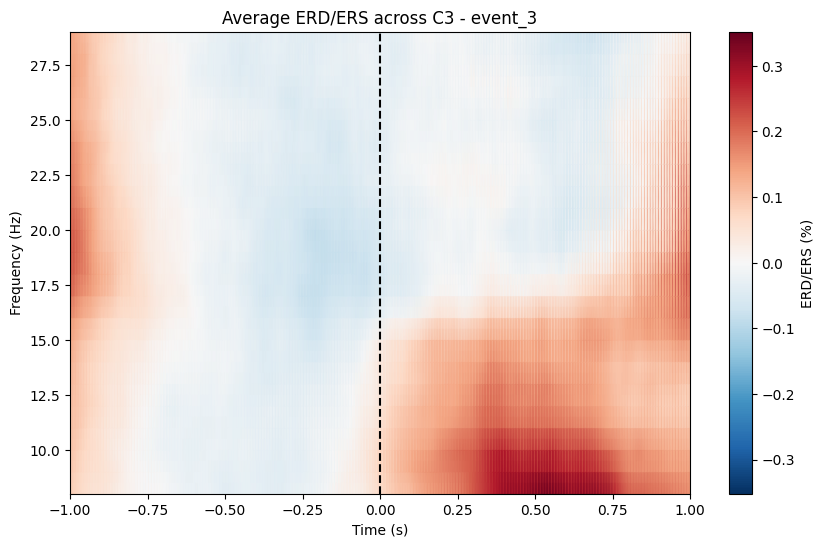

In [118]:
# plot_tfr.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Load the pre-processed data ---
processed_data_path = 'results/aggregated_5F_tfr.parquet' # Or the full path
print(f"Loading data from {processed_data_path}...")
tfr_df = pd.read_parquet(processed_data_path)
print("Data loaded successfully.")

# --- 2. Your plotting code (almost identical to the original) ---
# channels = ['C3', 'C4', 'CP3', 'CP1']
# conditions = ['S  9', 'S 10', 'S 11']

conditions = ['event_1', 'event_4', 'event_2', 'event_5', 'event_3']
channels = [ 'C3']

for condition in conditions:
    print(f"Generating plot for: Condition '{condition}' (averaged over all channels)")

    # --- Step 1: Select the data for the current condition ---
    condition_df = tfr_df[tfr_df['condition'] == condition].copy()

    # --- Step 2: Calculate the mean across the channel columns ---
    # The data is already averaged during the processing step, so we just select the power column
    # The column names might be the channel names themselves if not aggregated properly before saving.
    # Assuming the saved file has columns 'C3', 'C4', etc., representing power.
    condition_df['mean_channels'] = condition_df[channels].mean(axis=1)

    # --- Step 3: Pivot the data ---
    plot_matrix = condition_df.pivot_table(index='freq', columns='time', values='mean_channels')

    # --- Step 4: Create the plot ---
    fig, ax = plt.subplots(figsize=(10, 6))
    cmap = 'RdBu_r'
    
    # Set symmetric color limits
    vmax = np.max(np.abs(plot_matrix.values))
    vmin = -vmax

    mesh = ax.pcolormesh(
        plot_matrix.columns,
        plot_matrix.index,
        plot_matrix.values,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        shading='gouraud'
    )

    cbar = fig.colorbar(mesh, ax=ax)
    cbar.set_label('ERD/ERS (%)')

    ax.set_title(f'Average ERD/ERS across {', '.join(channels)} - {condition}')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Frequency (Hz)')
    ax.axvline(0, color='black', linestyle='--', linewidth=1.5)

    plt.show()

In [56]:
tfr_df.head(1)

,subject,condition,time,freq,epoch,Fp1,Fp2,F3,F4,C3,...,F7,F8,T3,T4,T5,T6,Fz,Cz,Pz,X5
0,5F-SubjectB-160311-5St-SGLHand-HFREQ,event_1,-1.0,8.0,505.593301,0.035957,0.10031,0.122058,0.117725,0.11256,...,0.10097,0.118417,0.055584,0.117567,0.079875,0.099451,0.08462,-0.063557,0.05299,-0.960971


In [78]:
id_vars = ['subject', 'condition', 'time', 'freq', 'epoch']

# Define the columns that are value variables (the channel names you want to unpivot)
# You can get these by taking all columns except the id_vars
value_vars = [col for col in tfr_df.columns if col not in id_vars]

# Perform the unpivot (melt) operation
df_melted = pd.melt(tfr_df, id_vars=id_vars, value_vars=value_vars,
                    var_name='channel', value_name='value')

In [79]:
df_melted = df_melted[df_melted['condition'].isin(['event_1', 'event_4', 'event_2', 'event_5', 'event_3'])]

In [80]:
df_melted['epoch'].unique()

array([505.59330144, 486.38728324, 464.26767677, 458.56315789,
       509.25396825, 492.18137255, 483.36470588, 455.05699482,
       448.48947368, 499.91847826, 500.42788462, 478.90751445,
       456.84848485, 451.79057592, 503.80319149, 491.02941176,
       473.75294118, 449.01036269, 451.66120219, 493.50810811,
       469.40718563, 484.9009901 , 463.14795918, 493.67368421,
       480.23152709, 505.02870813, 488.43604651, 463.66161616,
       458.63350785, 508.73015873, 488.89189189, 485.171875  ,
       487.52150538, 492.25988701, 435.95027624, 480.97536946,
       465.24550898, 445.30107527, 436.74456522, 489.80769231,
       497.96116505, 477.67455621, 458.13131313, 454.39572193,
       503.59677419, 549.9468599 , 531.19883041, 509.21649485,
       500.94086022, 551.87912088, 497.96618357, 480.46745562,
       458.54314721, 453.67553191, 499.68108108, 502.25242718,
       478.27745665, 456.33333333, 451.17277487, 501.12169312,
       501.32692308, 479.76878613, 457.71717172, 452.66

In [81]:
df = df_melted[df_melted['time'].between(0,1)][['subject', 'condition', 'channel', 'value', 'epoch']].groupby(['subject', 'condition', 'epoch', 'channel']).mean().reset_index()

In [82]:
df.subject.unique()

array(['5F-SubjectA-160405-5St-SGLHand',
       '5F-SubjectA-160408-5St-SGLHand-HFREQ',
       '5F-SubjectB-151110-5St-SGLHand',
       '5F-SubjectB-160309-5St-SGLHand-HFREQ',
       '5F-SubjectB-160311-5St-SGLHand-HFREQ',
       '5F-SubjectB-160316-5St-SGLHand', '5F-SubjectC-151204-5St-SGLHand',
       '5F-SubjectC-160429-5St-SGLHand-HFREQ', '5F-SubjectE',
       '5F-SubjectF-151027-5St-SGLHand', '5F-SubjectF-160209-5St-SGLHand',
       '5F-SubjectF-160210-5St-SGLHand-HFREQ',
       '5F-SubjectG-160413-5St-SGLHand-HFREQ',
       '5F-SubjectH-160804-5St-SGLHand-HFREQ',
       '5F-SubjectI-160719-5St-SGLHand-HFREQ'], dtype=object)

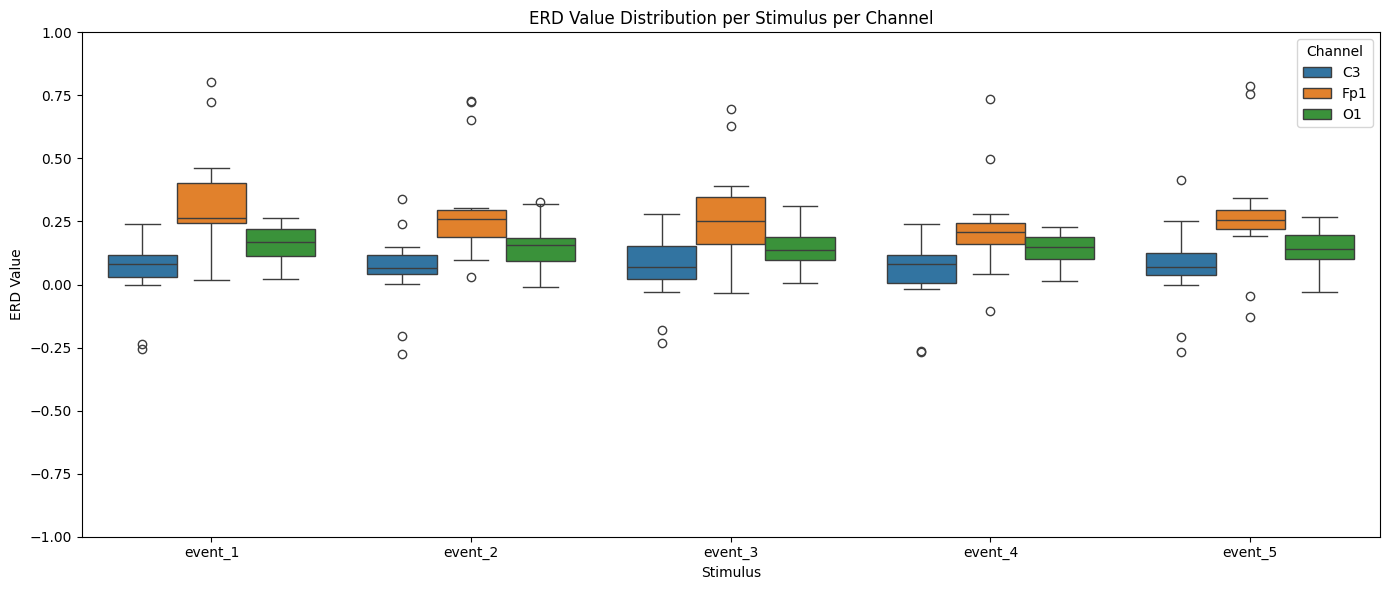

In [84]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=df[df['channel'].isin(['Fp1', 'C3', 'O1'])], x='condition', y='value', hue='channel')
plt.ylim(-1, 1)
plt.title('ERD Value Distribution per Stimulus per Channel')
plt.xlabel('Stimulus')
plt.ylabel('ERD Value')
plt.legend(title='Channel')
plt.tight_layout()
plt.show()
